# AutoARIMA Forecasting with Nixtla's NeuralForecast

## Dataset: KaggleWPGD

This notebook demonstrates how to use the classic LTM forecasting model described in:



The implementation we use is provided by Nixtla's NeuralForecast library:

+ for the base model [`LSTM`](https://nixtlaverse.nixtla.io/neuralforecast/models.lstm.html#lstm)
+ for the automodel [`AutoLSTM`](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autolstm)

## Important note:

This notebook uses the following conda environments:

+ Under linux: tfm_cc, described in the tfm_cc.yml file (see environments folder).
+ Under macOS: tfm_cc_nixtla, described in the tfm_cc_nixtla.yml file (see environments folder). 

## Execution Notes:

The run times that appear below correspond to the execution of the notebook in a Linux machine under Ubuntu 22.04 LTS with Intel Core i7-10870H CPU (2.20GHz), 64GB of RAM, NVIDIA GeForce RTX 3060 Laptop GPU with 6Gb VRAM.

## Load basic libraries

**Warning:** Model specific libraries will be loaded below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import logging



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


## Load dataset

The data in this notebook comes from the Kaggle dataset:

[Wind Power Generation Data - Forecasting](https://www.kaggle.com/datasets/mubashirrahim/wind-power-generation-data-forecasting/data)

In [2]:
file_path = "../../data/kaggleWPGD/Location1.csv"
df = pd.read_csv(file_path, delimiter=',')
df.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


### Set datetime format and index

In [3]:
df['time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:00')
df.drop(columns=['Time'], inplace=True)
df.set_index('time', inplace=True)
df.head()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
time,,,,,,,,,
2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2017-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature_2m       43800 non-null  float64
 1   relativehumidity_2m  43800 non-null  int64  
 2   dewpoint_2m          43800 non-null  float64
 3   windspeed_10m        43800 non-null  float64
 4   windspeed_100m       43800 non-null  float64
 5   winddirection_10m    43800 non-null  int64  
 6   winddirection_100m   43800 non-null  int64  
 7   windgusts_10m        43800 non-null  float64
 8   Power                43800 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 3.3 MB


### Select a subset of the data


In [5]:
df = df.head(7248)

### Rename the columns

In [6]:
initial_columns = df.columns.tolist()
initial_columns

['temperature_2m',
 'relativehumidity_2m',
 'dewpoint_2m',
 'windspeed_10m',
 'windspeed_100m',
 'winddirection_10m',
 'winddirection_100m',
 'windgusts_10m',
 'Power']

In [7]:
df.rename(columns={'Power' : 'Active_Power', 'windspeed_10m' : 'Wind_speed_tower'}, inplace=True)
df = df[['Active_Power', 'Wind_speed_tower']]
df

,Active_Power,Wind_speed_tower
time,,
2017-01-02 00:00:00,0.1635,1.44
2017-01-02 01:00:00,0.1424,2.06
2017-01-02 02:00:00,0.1214,1.30
2017-01-02 03:00:00,0.1003,1.30
2017-01-02 04:00:00,0.0793,2.47
...,...,...
2017-10-30 19:00:00,0.6847,5.89
2017-10-30 20:00:00,0.6841,6.32
2017-10-30 21:00:00,0.6834,6.52


### Check for missing values and duplicated dates

There are no missing data in this dataset

In [8]:
print(df.isna().sum())

Active_Power        0
Wind_speed_tower    0
dtype: int64


In [9]:
duplicate_dates = df.index[df.index.duplicated(keep='first')]
print(f"Number of duplicate timestamps: {len(duplicate_dates)}")
print(duplicate_dates)

Number of duplicate timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)


In [10]:
expected = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing = expected.difference(df.index)
print("Missing timestamps:", missing)



Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [11]:
missing_df = pd.DataFrame({'missing':missing})
missing_df['date'] = missing_df['missing'].dt.date
missing_df.value_counts('date').sort_index()

Series([], Name: count, dtype: int64)

### Target and exogenous variables

In [12]:
target = 'Active_Power'

features = [col for col in df.columns if col != target]
features = features[:1]
features


['Wind_speed_tower']

In [13]:
df = df[features + [target]]
df

,Wind_speed_tower,Active_Power
time,,
2017-01-02 00:00:00,1.44,0.1635
2017-01-02 01:00:00,2.06,0.1424
2017-01-02 02:00:00,1.30,0.1214
2017-01-02 03:00:00,1.30,0.1003
2017-01-02 04:00:00,2.47,0.0793
...,...,...
2017-10-30 19:00:00,5.89,0.6847
2017-10-30 20:00:00,6.32,0.6841
2017-10-30 21:00:00,6.52,0.6834


## Train / Validation / Test split

We select the following lengths for the train, validation, and test sets:

In [14]:
int(np.ceil(df.shape[0] * 0.8))

5799

In [15]:
train_len = 5800
print(f"Train length: {train_len}")

val_len = (df.shape[0] - train_len) // 2
print(f"Validation length: {val_len}")

test_len = df.shape[0] - train_len - val_len
print(f"Test length: {test_len}")

Train length: 5800
Validation length: 724
Test length: 724


And we split the time series into train, validation, and test sets:

In [16]:
train_df = df.iloc[:train_len]
train_df

,Wind_speed_tower,Active_Power
time,,
2017-01-02 00:00:00,1.44,0.1635
2017-01-02 01:00:00,2.06,0.1424
2017-01-02 02:00:00,1.30,0.1214
2017-01-02 03:00:00,1.30,0.1003
2017-01-02 04:00:00,2.47,0.0793
...,...,...
2017-08-31 11:00:00,4.83,0.6155
2017-08-31 12:00:00,5.15,0.5935
2017-08-31 13:00:00,5.47,0.5536


In [17]:
val_df = df.iloc[train_len:(train_len + val_len)]
val_df

,Wind_speed_tower,Active_Power
time,,
2017-08-31 16:00:00,5.87,0.4339
2017-08-31 17:00:00,5.19,0.3940
2017-08-31 18:00:00,4.26,0.3605
2017-08-31 19:00:00,2.21,0.3334
2017-08-31 20:00:00,2.55,0.3063
...,...,...
2017-09-30 15:00:00,2.12,0.0907
2017-09-30 16:00:00,2.42,0.0991
2017-09-30 17:00:00,2.10,0.1076


In [18]:
test_df = df.iloc[(train_len + val_len):]
test_df

,Wind_speed_tower,Active_Power
time,,
2017-09-30 20:00:00,1.80,0.1357
2017-09-30 21:00:00,1.71,0.1453
2017-09-30 22:00:00,1.44,0.1548
2017-09-30 23:00:00,1.40,0.1644
2017-10-01 00:00:00,2.20,0.1739
...,...,...
2017-10-30 19:00:00,5.89,0.6847
2017-10-30 20:00:00,6.32,0.6841
2017-10-30 21:00:00,6.52,0.6834


## Time series split visualization

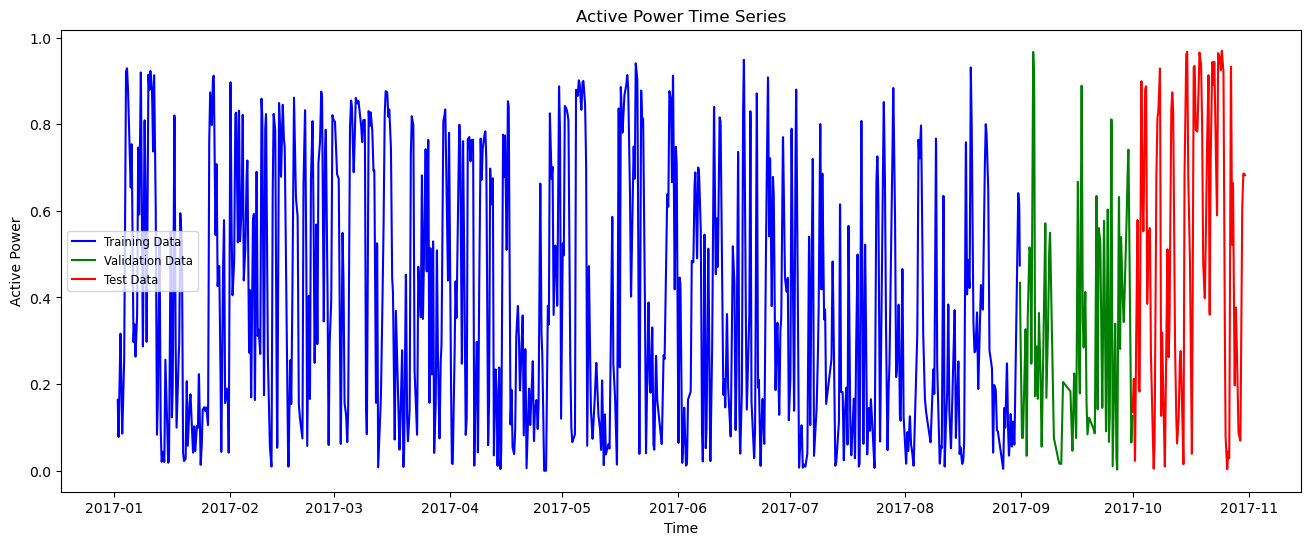

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(train_df["Active_Power"], label="Training Data", color='blue')
plt.plot(val_df["Active_Power"], label="Validation Data", color='green')
plt.plot(test_df["Active_Power"], label="Test Data", color='red')
plt.title("Active Power Time Series")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend(fontsize='small')

We will also create copies of the train, validation, and test sets to use them later in the notebook.

In [21]:
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

## Data scaling

We apply the min-max scaler fitted to the training set to the train, validation, and test sets (to avoid data leakage). 

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

scaler.fit(train_df)
train_df = scaler.transform(train_df)

val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

Let us check the result

In [23]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind_speed_tower,5800.0,0.275745,0.127310,0.0,0.184488,0.249247,0.348645,1.0
Active_Power,5800.0,0.407862,0.287194,0.0,0.149394,0.349394,0.669188,1.0


## Nixtla Dataset Format

Convert to NeuralForecast format (ds, y, unique_id)

In [24]:
train_df_nf = train_df.copy()

train_df_nf = train_df_nf.rename(columns={target: 'y'})

train_df_nf['ds'] = train_df_nf.index

train_df_nf['unique_id'] = 'series_1'


Move ds and unique_id to front

In [25]:
train_df_nf = train_df_nf[['unique_id', 'ds', 'y'] + features]
train_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-01-02 00:00:00,series_1,2017-01-02 00:00:00,0.172377,0.108434
2017-01-02 01:00:00,series_1,2017-01-02 01:00:00,0.150132,0.155120
2017-01-02 02:00:00,series_1,2017-01-02 02:00:00,0.127992,0.097892
2017-01-02 03:00:00,series_1,2017-01-02 03:00:00,0.105746,0.097892
2017-01-02 04:00:00,series_1,2017-01-02 04:00:00,0.083606,0.185994
...,...,...,...,...
2017-08-31 11:00:00,series_1,2017-08-31 11:00:00,0.648919,0.363705
2017-08-31 12:00:00,series_1,2017-08-31 12:00:00,0.625725,0.387801
2017-08-31 13:00:00,series_1,2017-08-31 13:00:00,0.583658,0.411898


Same for validation and test sets

In [26]:
val_df_nf = val_df.copy()
val_df_nf = val_df_nf.rename(columns={target: 'y'})
val_df_nf['ds'] = val_df_nf.index

val_df_nf['unique_id'] = 'series_1'

val_df_nf = val_df_nf[['unique_id', 'ds', 'y'] + features]
val_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-08-31 16:00:00,series_1,2017-08-31 16:00:00,0.457459,0.442018
2017-08-31 17:00:00,series_1,2017-08-31 17:00:00,0.415393,0.390813
2017-08-31 18:00:00,series_1,2017-08-31 18:00:00,0.380074,0.320783
2017-08-31 19:00:00,series_1,2017-08-31 19:00:00,0.351502,0.166416
2017-08-31 20:00:00,series_1,2017-08-31 20:00:00,0.322931,0.192018
...,...,...,...,...
2017-09-30 15:00:00,series_1,2017-09-30 15:00:00,0.095625,0.159639
2017-09-30 16:00:00,series_1,2017-09-30 16:00:00,0.104481,0.182229
2017-09-30 17:00:00,series_1,2017-09-30 17:00:00,0.113442,0.158133


In [27]:
test_df_nf = test_df.copy()
test_df_nf = test_df_nf.rename(columns={target: 'y'})
test_df_nf['ds'] = test_df_nf.index

test_df_nf['unique_id'] = 'series_1'

test_df_nf = test_df_nf[['unique_id', 'ds', 'y'] + features]
test_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-09-30 20:00:00,series_1,2017-09-30 20:00:00,0.143068,0.135542
2017-09-30 21:00:00,series_1,2017-09-30 21:00:00,0.153189,0.128765
2017-09-30 22:00:00,series_1,2017-09-30 22:00:00,0.163205,0.108434
2017-09-30 23:00:00,series_1,2017-09-30 23:00:00,0.173326,0.105422
2017-10-01 00:00:00,series_1,2017-10-01 00:00:00,0.183342,0.165663
...,...,...,...,...
2017-10-30 19:00:00,series_1,2017-10-30 19:00:00,0.721877,0.443524
2017-10-30 20:00:00,series_1,2017-10-30 20:00:00,0.721244,0.475904
2017-10-30 21:00:00,series_1,2017-10-30 21:00:00,0.720506,0.490964


Create a **joint dataset** with train and validation to fit into Nixtla's framework.

In [28]:
train_val_df = pd.concat([train_df_nf, val_df_nf], axis=0)
train_val_df.reset_index(drop=True, inplace=True)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         6524 non-null   object        
 1   ds                6524 non-null   datetime64[ns]
 2   y                 6524 non-null   float64       
 3   Wind_speed_tower  6524 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 204.0+ KB


And similarly a **full dataset** with train, validation and test sets.

In [29]:
full_df_nf = pd.concat([train_df_nf, val_df_nf, test_df_nf], axis=0)
full_df_nf.reset_index(drop=True, inplace=True)
full_df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         7248 non-null   object        
 1   ds                7248 non-null   datetime64[ns]
 2   y                 7248 non-null   float64       
 3   Wind_speed_tower  7248 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 226.6+ KB


## Set the forecast horizon and input length

In [30]:
horizon = 3
input_size = 6

# AutoARIMA

In [31]:
import logging

import optuna

import torch

from neuralforecast import NeuralForecast

from neuralforecast.losses.pytorch import MAE


Check if CUDA is available (Linux machines)

In [32]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [33]:
if torch.cuda.is_available():
    print(torch.cuda.device_count(), torch.cuda.current_device(),torch.cuda.get_device_name(0))

1 0 NVIDIA GeForce RTX 3060 Laptop GPU


Define the hyperparameters for the model. The first group is fixed and shouldn't changed from model to model. The second group is the hyperparameters that are tuned by the AutoTimeXer algorithm using Optuna as backend and may be specific to the model's architecture. The documentations for the hyperparameters can be seen at the [TimeXer](https://nixtlaverse.nixtla.io/neuralforecast/models.TimeXer.html#TimeXer) and [AutoTimeXer](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autoTimeXer) documentation.

In [34]:
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast

# Inicializar modelo AutoARIMA
model = StatsForecast(
    models=[AutoARIMA(start_p=1, start_q=1, max_p=3, max_q=3, seasonal=False)],
    freq='H',
    n_jobs=1
)

model

StatsForecast(models=[AutoARIMA])

In [35]:
sf = model.fit(df = train_val_df)


In [36]:
# ARIMA_model = sf.models[0]

In [37]:

from statsforecast.arima import ARIMASummary


In [38]:
ARIMA_model = sf.fitted_[0][0]


In [39]:
ARIMASummary(ARIMA_model.model_)

Regression with ARIMA(2,0,2) errors

In [40]:
ARIMA_model

AutoARIMA

In [41]:
summaries = []
for mdl in sf.fitted_[0]:
    summary_model = {
        "model": mdl,
        "Orders": ARIMASummary(mdl.model_),
        "sigma2": mdl.model_["sigma2"],
        "loglik": mdl.model_["loglik"],
        "aic": mdl.model_["aic"],
        "aicc": mdl.model_["aicc"],
        "bic": mdl.model_["bic"],
    }
    summaries.append(summary_model)

pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

,model,Orders,sigma2,loglik,aic,aicc,bic
0,AutoARIMA,"Regression with ARIMA(2,0,2) errors",0.000101,20749.021861,-41484.043721,-41484.026533,-41436.561021


In [42]:
summary_model['Orders']

Regression with ARIMA(2,0,2) errors

In [43]:
from copy import deepcopy
print(ARIMASummary(sf.fitted_[0, 0].model_))
coefs = deepcopy(sf.fitted_[0, 0].model_['coef'])
coefs["mean"] = coefs.pop("intercept")
print(f"Coefficients: {coefs}")

Regression with ARIMA(2,0,2) errors
Coefficients: {'ar1': 1.8114807407980238, 'ar2': -0.8279662078617853, 'ma1': 1.0448449854217952, 'ma2': 0.06390517253208748, 'ex_1': 5.758443660057455e-05, 'mean': 0.3961894497755289}


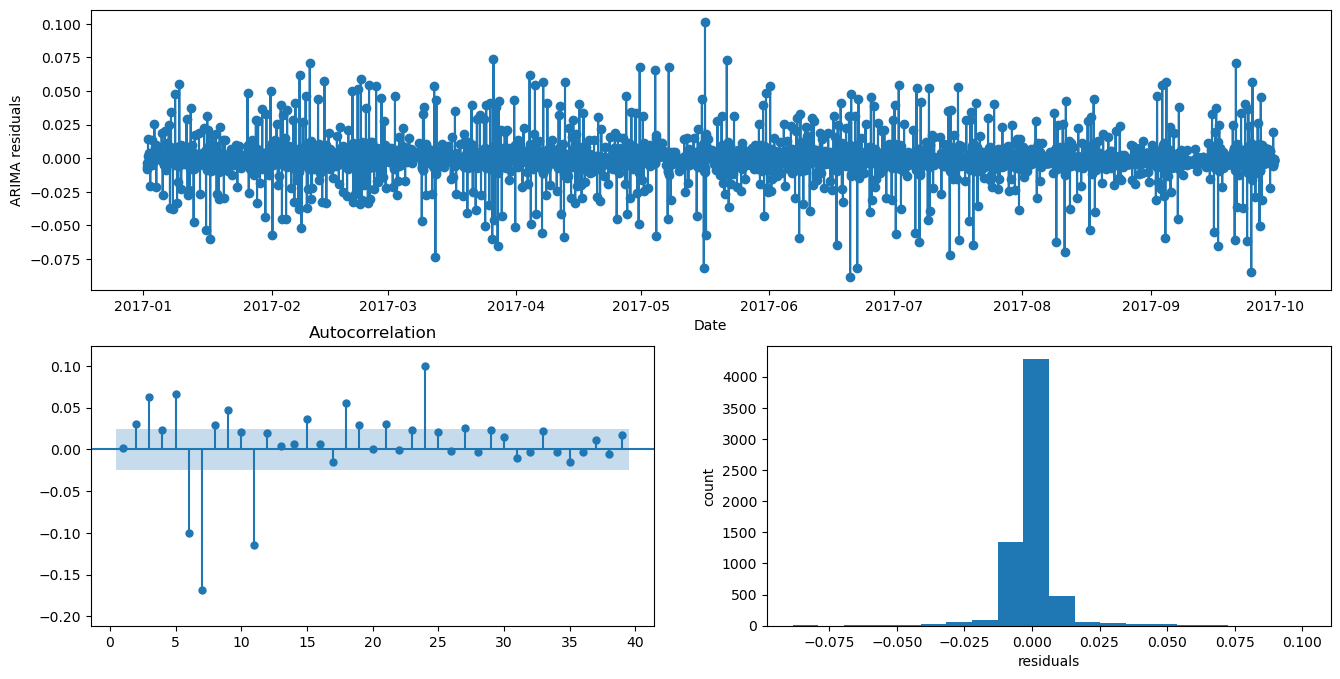

In [44]:
from statsmodels.graphics.tsaplots import plot_acf


fig = plt.figure(figsize=(16, 8))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
resids = sf.fitted_[0, 0].model_["residuals"]
ax1.plot(train_val_df['ds'], resids, marker="o")
ax1.set_ylabel('ARIMA residuals')
ax1.set_xlabel('Date')

plot_acf(resids, ax2, zero=False, auto_ylims=True, 
         bartlett_confint=False)

ax3.hist(resids, bins=20)
ax3.set_ylabel('count')
ax3.set_xlabel('residuals')

plt.show();plt.close()

In [45]:
full_df_nf

,unique_id,ds,y,Wind_speed_tower
0,series_1,2017-01-02 00:00:00,0.172377,0.108434
1,series_1,2017-01-02 01:00:00,0.150132,0.155120
2,series_1,2017-01-02 02:00:00,0.127992,0.097892
3,series_1,2017-01-02 03:00:00,0.105746,0.097892
4,series_1,2017-01-02 04:00:00,0.083606,0.185994
...,...,...,...,...
7243,series_1,2017-10-30 19:00:00,0.721877,0.443524
7244,series_1,2017-10-30 20:00:00,0.721244,0.475904
7245,series_1,2017-10-30 21:00:00,0.720506,0.490964
7246,series_1,2017-10-30 22:00:00,0.719873,0.476657


In [46]:
# The value of n moves across the test set, predicting one step at a time
# We use the first row (n = 0) of the test set to initialize the output DataFrame
n = 0 


In [47]:
from utilsforecast.processing import make_future_dataframe

future_predictors = make_future_dataframe(
    train_val_df["unique_id"].unique(),
    pd.to_datetime([train_val_df["ds"].max()]), 
    freq="H", 
    h=horizon,   
)

future_predictors

/home/fernando/miniconda3/envs/tfm_cc/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/fernando/miniconda3/envs/tfm_cc/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds
0,series_1,2017-09-30 20:00:00
1,series_1,2017-09-30 21:00:00
2,series_1,2017-09-30 22:00:00


In [48]:
future_predictors['Wind_speed_tower'] = [train_val_df['Wind_speed_tower'].tail(input_size).mean() for _ in range(future_predictors.shape[0])]
future_predictors

,unique_id,ds,Wind_speed_tower
0,series_1,2017-09-30 20:00:00,0.16491
1,series_1,2017-09-30 21:00:00,0.16491
2,series_1,2017-09-30 22:00:00,0.16491


In [49]:
forecast = sf.predict(h=3, X_df=future_predictors)
forecast

/home/fernando/miniconda3/envs/tfm_cc/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/fernando/miniconda3/envs/tfm_cc/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds,AutoARIMA
0,series_1,2017-09-30 20:00:00,0.145183
1,series_1,2017-09-30 21:00:00,0.159335
2,series_1,2017-09-30 22:00:00,0.174956


Now we create a dictionary (of dataframes) to store the predictions for each value k from 1 to the max of the prediction horizon. The weird (k-1):k bit below is to prevent pandas from collapsing the row into a series!

In [50]:
ARIMA_dict = {}

for h in range(1, horizon + 1):
# for h in range(1, 2):

    # Initialize the dictionary to store models and parameters for each horizon
    ARIMA_dict[f'{h}h'] = {'preds': forecast.iloc[(h - 1):h, :]}

ARIMA_dict['2h']['preds']

,unique_id,ds,AutoARIMA
1,series_1,2017-09-30 21:00:00,0.159335


In [51]:
%%capture

start_time = time.time()


# This loop iterates over the remaining rows of the test set, predicting one step at a time
# using the same steps
# for n in range(1, 10):
for n in range(1, test_df_nf.shape[0] - h + 1):

    print(f"Processing row {n} of the test set")
    train_val_df_n = full_df_nf.head(train_val_df.shape[0] + n).copy()

    sf_n = model.fit(df = train_val_df_n)


    future_predictors = make_future_dataframe(
    train_val_df_n["unique_id"].unique(),
    pd.to_datetime([train_val_df_n["ds"].max()]), 
    freq="H", 
    h=horizon,   
)

    future_predictors['Wind_speed_tower'] = [train_val_df_n['Wind_speed_tower'].tail(input_size).mean() for _ in range(future_predictors.shape[0])]

    forecast = sf.predict(h=3, X_df=future_predictors)

    for h in range(1, horizon + 1):
        
        ARIMA_dict[f'{h}h']['preds'] =   pd.concat([ARIMA_dict[f'{h}h']['preds'], forecast.iloc[(h - 1):h, :]], axis=0)
        ARIMA_dict[f'{h}h'][f'model_{n}'] = sf_n.fitted_[0, 0].model_
# future_predictors
# forecast
# ARIMA_dict['2h']['preds']

end_time = time.time()
elapsed_time = end_time - start_time    

In [52]:
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 5694.95 seconds


# Model Performance Evaluation

Let us also look at the prediction dataframes for the ARIMAoost models for each prediction horizon.

In [53]:
preds_df = {}

In [54]:
preds_df['1h'] = ARIMA_dict['1h']['preds'].set_index('ds').rename(columns={'AutoARIMA': 'pred_1h'})
preds_df['1h']

,unique_id,pred_1h
ds,,
2017-09-30 20:00:00,series_1,0.145183
2017-09-30 21:00:00,series_1,0.153298
2017-09-30 22:00:00,series_1,0.165329
2017-09-30 23:00:00,series_1,0.173096
2017-10-01 00:00:00,series_1,0.185465
...,...,...
2017-10-30 17:00:00,series_1,0.721137
2017-10-30 18:00:00,series_1,0.724705
2017-10-30 19:00:00,series_1,0.719981


In [55]:
preds_df['2h'] = ARIMA_dict['2h']['preds'].set_index('ds').rename(columns={'AutoARIMA': 'pred_2h'})
preds_df['2h']

,unique_id,pred_2h
ds,,
2017-09-30 21:00:00,series_1,0.159335
2017-09-30 22:00:00,series_1,0.165635
2017-09-30 23:00:00,series_1,0.179176
2017-10-01 00:00:00,series_1,0.184778
2017-10-01 01:00:00,series_1,0.198998
...,...,...
2017-10-30 18:00:00,series_1,0.719497
2017-10-30 19:00:00,series_1,0.726337
2017-10-30 20:00:00,series_1,0.717670


In [56]:
preds_df['3h'] = ARIMA_dict['3h']['preds'].set_index('ds').rename(columns={'AutoARIMA': 'pred_3h'})
preds_df['3h']

,unique_id,pred_3h
ds,,
2017-09-30 22:00:00,series_1,0.174956
2017-09-30 23:00:00,series_1,0.179650
2017-10-01 00:00:00,series_1,0.194218
2017-10-01 01:00:00,series_1,0.197894
2017-10-01 02:00:00,series_1,0.213452
...,...,...
2017-10-30 19:00:00,series_1,0.718044
2017-10-30 20:00:00,series_1,0.727791
2017-10-30 21:00:00,series_1,0.715647


And let us plot the predictions of the ARIMAoost models for each prediction horizon.

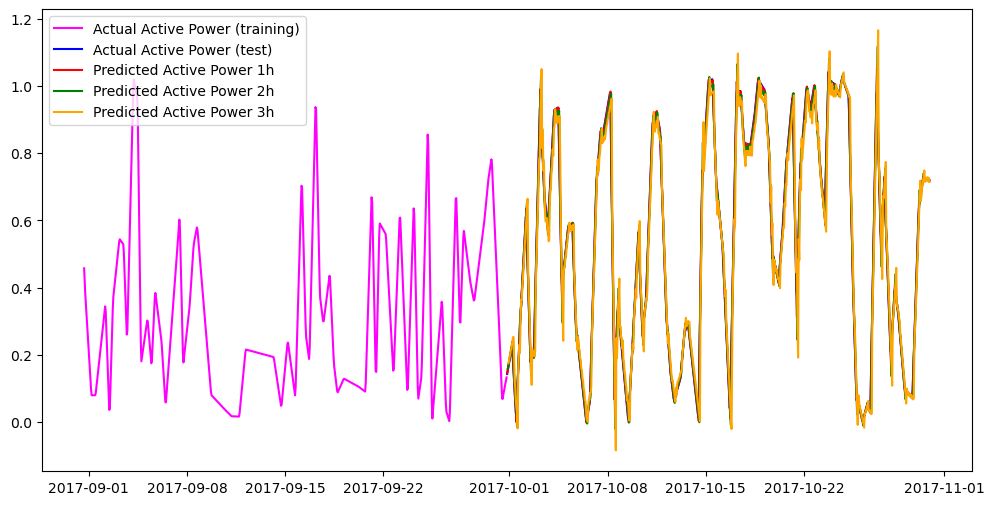

In [57]:
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(val_df_nf["y"], label="Actual Active Power (training)", color='magenta')
plt.plot(test_df_nf["y"], label="Actual Active Power (test)", color='blue')
for h in range(1, horizon + 1):
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'cyan']
    plt.plot(
        preds_df[f'{h}h'][f'pred_{h}h'],
        label=f"Predicted Active Power {h}h",
        color=colors[(h - 1) % len(colors)]
    )
plt.legend()
plt.show();plt.close()


### MAE computation

We will next compute the MAE for each of the predictions in the dictionary. 

In [58]:
from sklearn.metrics import mean_absolute_error

#### Mae for 1h preddictions

In [59]:
mae1h_df = preds_df['1h'].copy()[['pred_1h']]
mae1h_df


,pred_1h
ds,
2017-09-30 20:00:00,0.145183
2017-09-30 21:00:00,0.153298
2017-09-30 22:00:00,0.165329
2017-09-30 23:00:00,0.173096
2017-10-01 00:00:00,0.185465
...,...
2017-10-30 17:00:00,0.721137
2017-10-30 18:00:00,0.724705
2017-10-30 19:00:00,0.719981


We need to add the exogenous variables as they were used by the scaler. 

In [61]:
mae1h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae1h_df

,Wind_speed_tower,pred_1h
ds,,
2017-09-30 20:00:00,0.135542,0.145183
2017-09-30 21:00:00,0.128765,0.153298
2017-09-30 22:00:00,0.108434,0.165329
2017-09-30 23:00:00,0.105422,0.173096
2017-10-01 00:00:00,0.165663,0.185465
...,...,...
2017-10-30 17:00:00,0.443524,0.721137
2017-10-30 18:00:00,0.476657,0.724705
2017-10-30 19:00:00,0.443524,0.719981


In [62]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae1h_df)[:,1], test_df_original["Active_Power"][:-2])

0.0055083194962142505

#### Mae for 2h preddictions

In [63]:
mae2h_df = preds_df['2h'].copy()[['pred_2h']]
mae2h_df


,pred_2h
ds,
2017-09-30 21:00:00,0.159335
2017-09-30 22:00:00,0.165635
2017-09-30 23:00:00,0.179176
2017-10-01 00:00:00,0.184778
2017-10-01 01:00:00,0.198998
...,...
2017-10-30 18:00:00,0.719497
2017-10-30 19:00:00,0.726337
2017-10-30 20:00:00,0.717670


In [64]:
mae2h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae2h_df

,Wind_speed_tower,pred_2h
ds,,
2017-09-30 21:00:00,0.135542,0.159335
2017-09-30 22:00:00,0.128765,0.165635
2017-09-30 23:00:00,0.108434,0.179176
2017-10-01 00:00:00,0.105422,0.184778
2017-10-01 01:00:00,0.165663,0.198998
...,...,...
2017-10-30 18:00:00,0.443524,0.719497
2017-10-30 19:00:00,0.476657,0.726337
2017-10-30 20:00:00,0.443524,0.717670


In [65]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae2h_df)[:,1], test_df_original["Active_Power"][:-2])

0.02075974691550662

#### Mae for 3h preddictions

In [66]:
mae3h_df = preds_df['3h'].copy()[['pred_3h']]
mae3h_df


,pred_3h
ds,
2017-09-30 22:00:00,0.174956
2017-09-30 23:00:00,0.179650
2017-10-01 00:00:00,0.194218
2017-10-01 01:00:00,0.197894
2017-10-01 02:00:00,0.213452
...,...
2017-10-30 19:00:00,0.718044
2017-10-30 20:00:00,0.727791
2017-10-30 21:00:00,0.715647


In [67]:
mae3h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae3h_df

,Wind_speed_tower,pred_3h
ds,,
2017-09-30 22:00:00,0.135542,0.174956
2017-09-30 23:00:00,0.128765,0.179650
2017-10-01 00:00:00,0.108434,0.194218
2017-10-01 01:00:00,0.105422,0.197894
2017-10-01 02:00:00,0.165663,0.213452
...,...,...
2017-10-30 19:00:00,0.443524,0.718044
2017-10-30 20:00:00,0.476657,0.727791
2017-10-30 21:00:00,0.443524,0.715647


In [68]:
mean_absolute_error(scaler.inverse_transform(mae3h_df)[:,1], test_df_original["Active_Power"][:-2])

0.037362956581409944